# Problem Definition

I are tring to build a machine learning model to predict whether a customer will buy a product or not using the given dataset. The target is labled as 'Revenue' in the given dataset.

In [299]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

# Pre-model Analysis

In [300]:
df = pd.read_csv('coding_round_data.csv')
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [301]:
selection = pd.isnull(df).sum(axis=0)>0
print (selection)

Administrative             False
Administrative_Duration    False
Informational              False
Informational_Duration     False
ProductRelated             False
ProductRelated_Duration    False
BounceRates                False
ExitRates                  False
PageValues                 False
SpecialDay                 False
Month                      False
OperatingSystems           False
Browser                    False
Region                     False
TrafficType                False
VisitorType                False
Weekend                    False
Revenue                    False
dtype: bool


Here, we found that the dataset does not contain any nan values

In [302]:
# Pop target
target = df.pop('Revenue')

According to the instruction, there are 10 numerical features and 7 categorical features. I use min-max scaler for numerical features and one hot encoder for categorical features


In [303]:
num_col = ['Administrative','Administrative_Duration','Informational','Informational_Duration','ProductRelated','ProductRelated_Duration','BounceRates','ExitRates','PageValues','SpecialDay']
num_df = df[num_col]
cat_df = df.loc[:,~df.columns.isin(num_col)]

In [304]:
cat_df.nunique(dropna=False)

Month               10
OperatingSystems     8
Browser             13
Region               9
TrafficType         20
VisitorType          3
Weekend              2
dtype: int64

In [305]:
#print counts of each categorical variable
for col in cat_df:
    print(cat_df[col].value_counts(dropna=False),'\n')

May     3364
Nov     2998
Mar     1907
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: Month, dtype: int64 

2    6601
1    2585
3    2555
4     478
8      79
6      19
7       7
5       6
Name: OperatingSystems, dtype: int64 

2     7961
1     2462
4      736
5      467
6      174
10     163
8      135
3      105
13      61
7       49
12      10
11       6
9        1
Name: Browser, dtype: int64 

1    4780
3    2403
4    1182
2    1136
6     805
7     761
9     511
8     434
5     318
Name: Region, dtype: int64 

2     3913
1     2451
3     2052
4     1069
13     738
10     450
6      444
8      343
5      260
11     247
20     198
9       42
7       40
15      38
19      17
14      13
18      10
16       3
12       1
17       1
Name: TrafficType, dtype: int64 

Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: VisitorType, dtype: int64 

False    9462
True     2868
Name: Weekend, dtype: int64 



In [306]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Modeling and Feature Engineering

I first run logistic regression with only the numerical variables

In [314]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(num_df,
                                  target,
                                  test_size=0.2,
                                  random_state=2)

In [315]:
# rescale the numerical features
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))

Here, I use recursive feature reduction with cross validation to train a logistic regression model.

In [316]:
rfe_lr = RFECV(LogisticRegression(max_iter=200),
      scoring = 'roc_auc',
      n_jobs = -1,
      cv = 3,
      step = 1)

In [317]:
rfe_lr.fit(X_train_scaled, y_train)

rfe_lr_probs = rfe_lr.predict_proba(X_test_scaled)
rfe_lr_training_probs = rfe_lr.predict_proba(X_train_scaled)
print('Training AUC: ', roc_auc_score(y_train, rfe_lr_training_probs[:,1]))
print('Testing AUC: ', roc_auc_score(y_test, rfe_lr_probs[:,1]))

Training AUC:  0.8741134592838066
Testing AUC:  0.8521948420199837


I also used all numerical features to train a logistic regression model.

In [318]:
reg = LogisticRegression()
reg.fit(X_train_scaled,y_train)
reg_probs = reg.predict_proba(X_test_scaled)
reg_training_probs = reg.predict_proba(X_train_scaled)
print('All feature training LR AUC: ', roc_auc_score(y_train, reg_training_probs[:,1]))
print('All feature testing LR AUC: ', roc_auc_score(y_test, reg_probs[:,1]))

All feature training LR AUC:  0.8741001679346511
All feature testing LR AUC:  0.8521570348366189


The two models ended up with similar test AUC scores. The RFECV recommended features are shown as below

In [319]:
print (num_df.columns[rfe_lr.support_])
reg = LogisticRegression()
reg.fit(X_train_scaled.loc[:,rfe_lr.support_],y_train)
reg_probs = reg.predict_proba(X_test_scaled.loc[:,rfe_lr.support_])
print('Features after RFE AUC: ', roc_auc_score(y_test, reg_probs[:,1]))

Index(['Administrative', 'Informational', 'Informational_Duration',
       'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates',
       'PageValues', 'SpecialDay'],
      dtype='object')
Features after RFE AUC:  0.8521948420199837


Now, I am going to train the models with all the features, including numerical features and categorical features

In [326]:
X_train, X_test, y_train, y_test = train_test_split(df,
                                  target,
                                  test_size=0.2,
                                  random_state=2)

In [327]:
num_col = ['Administrative','Administrative_Duration','Informational','Informational_Duration','ProductRelated','ProductRelated_Duration','BounceRates','ExitRates','PageValues','SpecialDay']
num_df_train = X_train[num_col]
num_df_test = X_test[num_col]
cat_df_train = X_train.loc[:,~X_train.columns.isin(num_col)]
cat_df_test = X_test.loc[:,~X_test.columns.isin(num_col)]

In [328]:
# create dummy variables for trainining set
month_dummy = pd.get_dummies(cat_df_train['Month'])
visitor_dummy = pd.get_dummies(cat_df_train['VisitorType'])
weekend_dummy = pd.get_dummies(cat_df_train['Weekend'])
cat_df_train.drop(['Month','VisitorType','Weekend'],axis = 1, inplace = True)

cat_df_train = pd.concat([cat_df_train,month_dummy,visitor_dummy,weekend_dummy],axis = 1)

# create dummy variables for test set
month_dummy = pd.get_dummies(cat_df_test['Month'])
visitor_dummy = pd.get_dummies(cat_df_test['VisitorType'])
weekend_dummy = pd.get_dummies(cat_df_test['Weekend'])
cat_df_test.drop(['Month','VisitorType','Weekend'],axis = 1, inplace = True)

cat_df_test = pd.concat([cat_df_test,month_dummy,visitor_dummy,weekend_dummy],axis = 1)

C:\Users\xli22\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [329]:
# scale numerical data
X_train_s = (num_df_train-num_df_train.min())/(num_df_train.max()-num_df_train.min())
X_test_s = (num_df_test-num_df_train.min())/(num_df_train.max()-num_df_train.min())

In [330]:
# Concatenate numerical and categorical features
X_train_processed = pd.concat([X_train_s, cat_df_train], axis = 1)
X_test_processed = pd.concat([X_test_s, cat_df_test], axis = 1)

In [331]:
X_train_processed.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Mar,May,Nov,Oct,Sep,New_Visitor,Other,Returning_Visitor,False,True
6183,0.000000,0.000000,0.000000,0.000000,0.004373,0.000788,0.000000,0.333333,0.000000,0.0,...,0,0,0,0,0,0,0,1,1,0
9253,0.333333,0.019174,0.000000,0.000000,0.179300,0.093313,0.007692,0.069615,0.029556,0.0,...,0,0,1,0,0,1,0,0,1,0
2927,0.000000,0.000000,0.071429,0.017259,0.020408,0.008589,0.000000,0.066667,0.119559,0.2,...,0,1,0,0,0,1,0,0,1,0
7192,0.259259,0.060051,0.000000,0.000000,0.007289,0.002012,0.000000,0.062500,0.000000,0.0,...,0,0,0,0,1,1,0,0,1,0
3869,0.074074,0.007503,0.000000,0.000000,0.018950,0.014201,0.000000,0.066667,0.054691,0.0,...,0,1,0,0,0,0,0,1,0,1


Here, I use recursive feature reduction with cross validation to train a logistic regression model with all the features.

In [332]:
clf2 = RFECV(LogisticRegression(max_iter=1000),
      scoring = 'roc_auc',
      n_jobs = -1,
      cv = 3,
      step = 1)

In [333]:
clf2.fit(X_train_processed, y_train)

clf2_probs = clf2.predict_proba(X_test_processed)
print('AUC: ', roc_auc_score(y_test, clf2_probs[:,1]))

C:\Users\xli22\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(


AUC:  0.8721043748312179


C:\Users\xli22\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(


The AUC score (0.87) is slightly higher than the model using only the numerical features (0.86).
I can also take a look at the RFECV recommended features as shown below

In [334]:
lr_col = X_train_processed.columns[clf2.support_]
print (lr_col)

Index(['Informational', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'Feb', 'Nov'],
      dtype='object')


Now, I try to use all features to build a logistic regression model without using RFECV.The AUC score of this model is still around 0.87.

In [335]:
#Logistic regression with all features vs Logistic regression with RFE recomended features
lr = LogisticRegression()
lr.fit(X_train_processed, y_train)
lr_probs = lr.predict_proba(X_test_processed)
print('Logistic regression with all numreical and categorical AUC: ', roc_auc_score(y_test, lr_probs[:,1]))

X_train_lr = X_train_processed[lr_col]
X_test_lr = X_test_processed[lr_col]
lr = LogisticRegression()
lr.fit(X_train_lr, y_train)
lr_probs = lr.predict_proba(X_test_lr)
print('Logistic regression with RFE recommended numreical and categorical AUC AUC: ', roc_auc_score(y_test, lr_probs[:,1]))

C:\Users\xli22\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\xli22\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\xli22\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn

Logistic regression with all numreical and categorical AUC:  0.8784229003510667
Logistic regression with RFE recommended numreical and categorical AUC AUC:  0.8721043748312179


Now, I use all the features to train a random forest model with RFECV

In [336]:
clf2 = RFECV(RandomForestClassifier(),
      scoring = 'roc_auc',
      n_jobs = -1,
      cv = 3,
      step = 1)

In [337]:
clf2.fit(X_train_processed, y_train)
clf2_probs = clf2.predict_proba(X_test_processed)
print('AUC: ', roc_auc_score(y_test, clf2_probs[:,1]))

C:\Users\xli22\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(


AUC:  0.9147481771536592


C:\Users\xli22\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [338]:
rf_col = X_train_processed.columns[clf2.support_]
print (rf_col)
print (len(rf_col))

Index([         'Administrative', 'Administrative_Duration',
                 'Informational',  'Informational_Duration',
                'ProductRelated', 'ProductRelated_Duration',
                   'BounceRates',               'ExitRates',
                    'PageValues',              'SpecialDay',
              'OperatingSystems',                 'Browser',
                        'Region',             'TrafficType',
                           'Aug',                     'Dec',
                           'Jul',                    'June',
                           'Mar',                     'May',
                           'Nov',                     'Oct',
                           'Sep',             'New_Visitor',
                         'Other',       'Returning_Visitor',
                           False,                      True],
      dtype='object')
28


In [339]:
X_train_rf = X_train_processed.loc[:,clf2.support_]
X_test_rf = X_test_processed.loc[:,clf2.support_]

In [340]:
# Random forest classifier with all features vs with RFE recommende features
rf_all = RandomForestClassifier()
rf_all.fit(X_train_processed, y_train)
rf_all_probs = rf_all.predict_proba(X_test_processed)
print('Random Forest classifier with all features AUC: ', roc_auc_score(y_test, rf_all_probs[:,1]))

rf = RandomForestClassifier()
rf.fit(X_train_rf, y_train)
rf_probs = rf.predict_proba(X_test_rf)
print('Random Forest classifier with RFE recommended features AUC: ', roc_auc_score(y_test, rf_probs[:,1]))

C:\Users\xli22\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\xli22\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(


Random Forest classifier with all features AUC:  0.9189015662975966


C:\Users\xli22\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(


Random Forest classifier with RFE recommended features AUC:  0.918004320820956


C:\Users\xli22\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(


Random forest model achieved a AUC score of 0.92, which is higher than what I obtained from logistic regression model. In the mean time, I noticed that that eliminating features using RFECV  does not make a significant difference in model performance.

<BarContainer object of 26 artists>

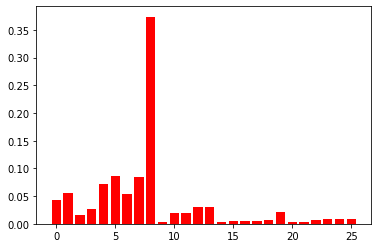

In [171]:
# take a look at the feature importance in random forest model
importances = rf.feature_importances_
plt.bar(range(len(importances)), importances, color="r", align = "center")

Here, I found that the most important feature in this model is Page Values.

Now, I am going to check the collinearity within the given dataset. Collinearity may affect the model performance and feature importance in logistic regression model I built earlier. 

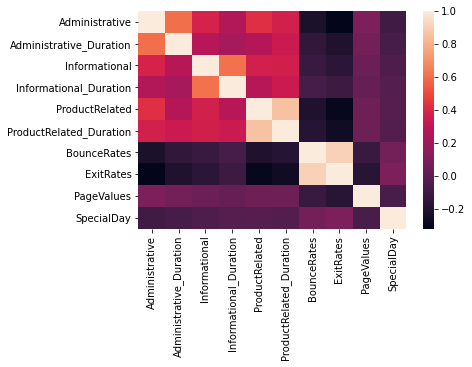

In [341]:
sns.heatmap(X_train_s.corr());

By observing the colinearity heat map, I found that Administrative and Administrative duration are highly correlated. Informational and Informational duration are correlated. Product related and product related duration are correlated. Bounce rate and exit rates are correlated.
So I would keep only one feature for each pair.

I build a logistic regression model with the non-linearly releated features.

In [186]:
X_train_col = X_train_s.drop(['Administrative','Informational','ProductRelated','BounceRates'],axis = 1)
X_test_col = X_test_s.drop(['Administrative','Informational','ProductRelated','BounceRates'],axis = 1)

In [189]:
# Concatenate numerical and categorical features
X_train_remove_colinear = pd.concat([X_train_col, cat_df_train], axis = 1)
X_test_remove_colinear = pd.concat([X_test_col, cat_df_test], axis = 1)

In [282]:
# Logistic regression with non-colinear features
reg = LogisticRegression(max_iter=1000)
reg.fit(X_train_remove_colinear, y_train)
reg_probs = reg.predict_proba(X_test_remove_colinear)
print('AUC: ', roc_auc_score(y_test, reg_probs[:,1]))

C:\Users\xli22\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(


AUC:  0.888393175863625


C:\Users\xli22\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(


<BarContainer object of 25 artists>

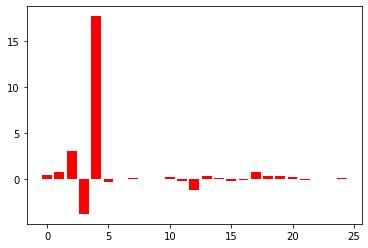

In [283]:
plt.bar(range(len(reg.coef_[0])), reg.coef_[0], color="r", align = "center")

<BarContainer object of 6 artists>

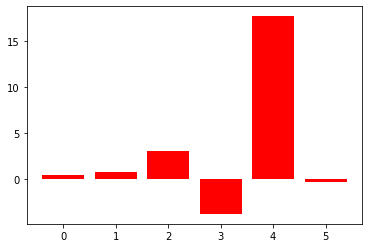

In [284]:
plt.bar(range(len(reg.coef_[0][0:6])), reg.coef_[0][0:6], color="r", align = "center")

In [201]:
X_train_col.columns

Index(['Administrative_Duration', 'Informational_Duration',
       'ProductRelated_Duration', 'ExitRates', 'PageValues', 'SpecialDay'],
      dtype='object')

By looking at the feature importance in logstic regression model, I found that PageValues is still the most important feature.

Here, I build a random forest model with non-linearly related features.

In [287]:
# Random Forest with non-colinear features
rf_non_colinear = RandomForestClassifier()
rf_non_colinear.fit(X_train_remove_colinear, y_train)
rf_non_colinear_probs = rf_non_colinear.predict_proba(X_test_remove_colinear)
print('AUC: ', roc_auc_score(y_test, rf_non_colinear_probs[:,1]))

C:\Users\xli22\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(


AUC:  0.927703353471675


C:\Users\xli22\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['bool', 'str']. An error will be raised in 1.2.
  warnings.warn(


<BarContainer object of 25 artists>

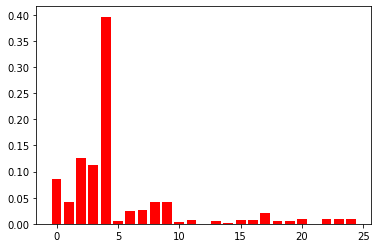

In [288]:
importances = rf_non_colinear.feature_importances_
plt.bar(range(len(importances)), importances, color="r", align = "center")

<BarContainer object of 6 artists>

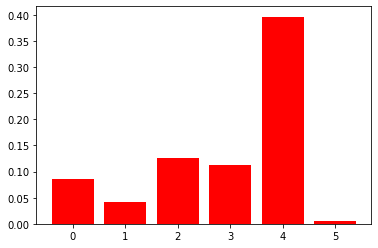

In [289]:
plt.bar(range(len(importances[0:6])), importances[0:6], color="r", align = "center")

In random forest model, 'Administrative_Duration', 'Informational_Duration',
       'ProductRelated_Duration', 'ExitRates', 'PageValues' have high feature importance, where the PageValues have highest feature importance.

Now, I will try to wrap up everything with a pipeline

In [296]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector as selector


numerical_columns = ['Administrative', 'Administrative_Duration',
 'Informational',
 'Informational_Duration',
 'ProductRelated',
 'ProductRelated_Duration',
 'BounceRates',
 'ExitRates',
 'PageValues',
 'SpecialDay',
 'OperatingSystems',
 'Browser',
 'Region',
 'TrafficType']
categorical_columns = ['Month', 'VisitorType','Weekend']

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('minmax_scaler', numerical_preprocessor, numerical_columns)])


In [297]:
model_pipeline = make_pipeline(preprocessor, RandomForestClassifier(class_weight = 'balanced'))
model_pipeline.fit(X_train, y_train)
model_pipeline.score(X_test, y_test)

0.9022708840227088

In [273]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
parameters = {
    'randomforestclassifier__n_estimators':[1,10,100,1000],
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__min_samples_split': [2,3,4,5],
    'randomforestclassifier__max_depth': [2,5,8,10],
    'randomforestclassifier__max_features':['auto','sqrt']
}


rv = RandomizedSearchCV(model_pipeline,param_distributions = parameters, cv = 5, verbose = 2, n_iter = 20)

rv.fit(X_train,y_train)
rv.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=5, randomforestclassifier__max_features=sqrt, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=10; total time=   0.1s
[CV] END randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=5, randomforestclassifier__max_features=sqrt, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=10; total time=   0.1s
[CV] END randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=5, randomforestclassifier__max_features=sqrt, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=10; total time=   0.1s
[CV] END randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=5, randomforestclassifier__max_features=sqrt, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=10; total tim

[CV] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=2, randomforestclassifier__max_features=sqrt, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=1; total time=   0.0s
[CV] END randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=10, randomforestclassifier__max_features=sqrt, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=1000; total time=  12.1s
[CV] END randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=10, randomforestclassifier__max_features=sqrt, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=1000; total time=  11.1s
[CV] END randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=10, randomforestclassifier__max_features=sqrt, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=1000; total time=  10.7s
[CV] END randomforestclassifier__criterion=entr

[CV] END randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=2, randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_split=3, randomforestclassifier__n_estimators=1; total time=   0.0s
[CV] END randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=10, randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=10; total time=   0.1s
[CV] END randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=10, randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=10; total time=   0.1s
[CV] END randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=10, randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=10; total time=   0.1s
[CV] END randomforestclassifier__criterion=entropy

{'randomforestclassifier__n_estimators': 1000,
 'randomforestclassifier__min_samples_split': 5,
 'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__criterion': 'gini'}

In [276]:
from sklearn.model_selection import RandomizedSearchCV

parameters = {'randomforestclassifier__max_depth': [6,8,10,12,15,18]}

gd = GridSearchCV(model_pipeline,param_grid = parameters, cv = 5, verbose = 2)

gd.fit(X_train,y_train)
gd.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ................randomforestclassifier__max_depth=6; total time=   0.6s
[CV] END ................randomforestclassifier__max_depth=6; total time=   0.5s
[CV] END ................randomforestclassifier__max_depth=6; total time=   0.5s
[CV] END ................randomforestclassifier__max_depth=6; total time=   0.6s
[CV] END ................randomforestclassifier__max_depth=6; total time=   0.5s
[CV] END ................randomforestclassifier__max_depth=8; total time=   0.7s
[CV] END ................randomforestclassifier__max_depth=8; total time=   0.7s
[CV] END ................randomforestclassifier__max_depth=8; total time=   0.6s
[CV] END ................randomforestclassifier__max_depth=8; total time=   0.7s
[CV] END ................randomforestclassifier__max_depth=8; total time=   0.7s
[CV] END ...............randomforestclassifier__max_depth=10; total time=   0.7s
[CV] END ...............randomforestclassifier__m

{'randomforestclassifier__max_depth': 18}

In [279]:
model_pipeline_param = make_pipeline(preprocessor, 
                       RandomForestClassifier(class_weight = 'balanced',
                                              max_depth = 18, max_features = 'auto',
                                              min_samples_split = 2,criterion = 'gini', n_estimators = 1000))
model_pipeline_param.fit(X_train, y_train)
model_pipeline_param.score(X_test, y_test)

0.9071370640713706

[]

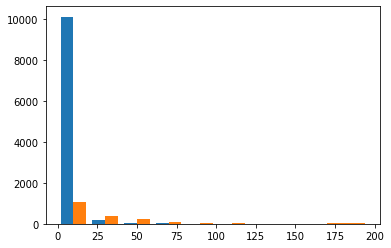

In [298]:
ind0 = target == 0
data_neg = df[ind0]
data_pos = df[~ind0]
plt.hist([data_neg['PageValues'], data_pos['PageValues']], bins = [0,20,40,60,80,100,120,140, 200])

plt.plot()

# Post-model Analysis

1. Logistic regression and Random Forest models both ended up with high AUC scores (higher than 0.8).
2. For logistic regression, using both numerical and categorical features only shows slight increase in the AUC score, indicating that the numerical features are dominating the revenue.
3. RFECV are able to effectively remove features from the logistic regression model while maintaining the AUC score.
4. Intuitively administration and administration duration, informational and informational duration, product related and product related duration are colinear features. Bouncerate and exitrate are also linearly correlated. Thus I remove one feature for each pair. Fitted logistic regression and random forest model achieve similar AUC score as the models that were trained with all data.
5. After eliminating the colinear features, I determined that Pagevalues are the most dominant feature. This is showed in both logistic regression and random forest feature importance analyses. Product related duration and exit rates are the other 2 most important features in both models.
6. I plot the distribution of page values for positive and negative revenues. I found that revenue is mostly negative when page values is 0, whereas positive when page values are greater than 0. 
7. The model performance did not improve much with fine tuning the hyper parameters of the random forest model since the AUC score is already high.